## Midterm project

CITATIONS:
- https://github.com/poojahira/gtsrb-pytorch
- https://github.com/surajmurthy/TSR_PyTorch

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
from torch.utils import data
from torch.autograd import Variable
from torchvision.io import read_image
from model import GTSRBnet

## Training

Number of training samples = 35288
Number of validation samples = 3921


Text(0, 0.5, '# of examples')

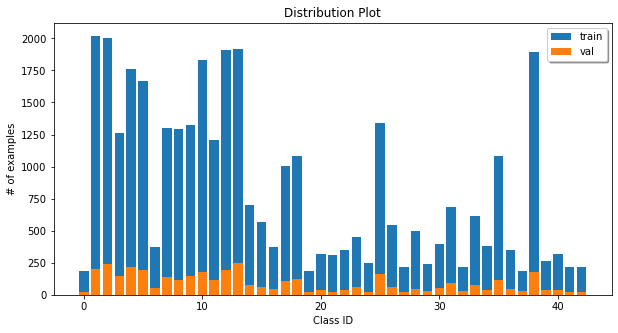

In [2]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize([212, 256]),
    transforms.ToTensor()
])

# Define path of training data
train_data_path = '/home/stringlab/Desktop/DLCV_midterm_project/GTSRB_Final_Training_Images/GTSRB/Final_Training/Images' 
train_data = torchvision.datasets.ImageFolder(root = train_data_path, transform=transform)

# Divide data into training and validation set
train_ratio = 0.9
n_train_examples = int(len(train_data) * train_ratio)
n_val_examples = len(train_data) - n_train_examples

train_data, val_data = data.random_split(train_data, [n_train_examples, n_val_examples])
print(f"Number of training samples = {len(train_data)}")
print(f"Number of validation samples = {len(val_data)}")

num_train_classes = len(train_data.dataset.classes)
train_hist = [0]*num_train_classes
for i in train_data.indices:
    tar = train_data.dataset.targets[i]
    train_hist[tar] += 1

num_val_classes = len(val_data.dataset.classes)
val_hist = [0]*num_val_classes
for i in val_data.indices:
    tar = val_data.dataset.targets[i]
    val_hist[tar] += 1

plt.figure(figsize=(10, 5))
plt.bar(range(num_train_classes), train_hist, label="train")
plt.bar(range(num_val_classes), val_hist, label="val")
#plt.bar(range(num_test_classes), test_hist, label="test")
legend = plt.legend(loc='upper right', shadow=True)
plt.title("Distribution Plot")
plt.xlabel("Class ID")
plt.ylabel("# of examples")

In [3]:
# Create data loader for training and validation
BATCH_SIZE = 100
LOG_INTERVAL = 100
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_loader = data.DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE)
val_loader = data.DataLoader(val_data, shuffle=True, batch_size=BATCH_SIZE)

# Neural Network and Optimizer
model = GTSRBnet(num_train_classes)
model = model.to(device);

# Define loss function and optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5, verbose=True)

In [4]:
def train(epoch):
    model.train()
    correct = 0
    training_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        data, target = data.to(device), target.to(device)   
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        max_index = output.max(dim = 1)[1]
        correct += (max_index == target).sum()
        training_loss += loss
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss per example: {:.6f}\tLoss: {:.6f}'.format(
                        epoch, batch_idx * len(data), len(train_loader.dataset),
                        100. * batch_idx / len(train_loader), loss.data.item()/(BATCH_SIZE * LOG_INTERVAL),loss.data.item()))
    avg_train_loss = training_loss / len(train_loader.dataset)
    avg_train_acc = 100. * correct / len(train_loader.dataset)
    print('\nTraining set: Average loss: {:.4f}, Accuracy: {:.0f}%\n'.format(
                avg_train_loss, avg_train_acc))
    return avg_train_loss, avg_train_acc

def validation():
    model.eval()
    validation_loss = 0
    correct = 0
    for data, target in val_loader:
        with torch.no_grad():
            data, target = Variable(data), Variable(target)
            data, target = data.to(device), target.to(device)
            output = model(data)
            validation_loss += F.nll_loss(output, target, size_average=False).data.item() # sum up batch loss
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    validation_loss /= len(val_loader.dataset)
    scheduler.step(np.around(validation_loss,2))
    validation_acc = 100. * correct / len(val_loader.dataset)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {:.0f}%\n'.format(
        validation_loss, validation_acc))
    return validation_loss, validation_acc


In [5]:
train_loss, train_acc = [], []
val_loss, val_acc = [], []
for epoch in range(1, 50):
    avg_train_loss, avg_train_acc = train(epoch)
    avg_val_loss, avg_val_acc = validation()
    train_loss.append(avg_train_loss)
    train_acc.append(avg_train_acc)
    val_loss.append(avg_val_loss)
    val_acc.append(avg_val_acc)
    model_file = 'trained_models/model_' + str(epoch) + '.pth'
    torch.save(model.state_dict(), model_file)
    print('\nSaved model to ' + model_file)

Train Epoch: 1 [0/35288 (0%)]	Loss per example: 0.000377	Loss: 3.771584
Train Epoch: 1 [1000/35288 (3%)]	Loss per example: 0.000380	Loss: 3.798339
Train Epoch: 1 [2000/35288 (6%)]	Loss per example: 0.000417	Loss: 4.168219
Train Epoch: 1 [3000/35288 (8%)]	Loss per example: 0.000377	Loss: 3.771859
Train Epoch: 1 [4000/35288 (11%)]	Loss per example: 0.000371	Loss: 3.710956
Train Epoch: 1 [5000/35288 (14%)]	Loss per example: 0.000363	Loss: 3.630858
Train Epoch: 1 [6000/35288 (17%)]	Loss per example: 0.000361	Loss: 3.606360
Train Epoch: 1 [7000/35288 (20%)]	Loss per example: 0.000372	Loss: 3.716578
Train Epoch: 1 [8000/35288 (23%)]	Loss per example: 0.000365	Loss: 3.646364
Train Epoch: 1 [9000/35288 (25%)]	Loss per example: 0.000358	Loss: 3.578210
Train Epoch: 1 [10000/35288 (28%)]	Loss per example: 0.000363	Loss: 3.630767
Train Epoch: 1 [11000/35288 (31%)]	Loss per example: 0.000364	Loss: 3.643912
Train Epoch: 1 [12000/35288 (34%)]	Loss per example: 0.000353	Loss: 3.528560
Train Epoch: 1 [

/home/stringlab/anaconda3/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Validation set: Average loss: 1.6341, Accuracy: 50%


Saved model to trained_models/model_1.pth
Train Epoch: 2 [0/35288 (0%)]	Loss per example: 0.000199	Loss: 1.993444
Train Epoch: 2 [1000/35288 (3%)]	Loss per example: 0.000223	Loss: 2.231097
Train Epoch: 2 [2000/35288 (6%)]	Loss per example: 0.000169	Loss: 1.693544
Train Epoch: 2 [3000/35288 (8%)]	Loss per example: 0.000174	Loss: 1.736700
Train Epoch: 2 [4000/35288 (11%)]	Loss per example: 0.000186	Loss: 1.862376
Train Epoch: 2 [5000/35288 (14%)]	Loss per example: 0.000132	Loss: 1.322963
Train Epoch: 2 [6000/35288 (17%)]	Loss per example: 0.000129	Loss: 1.290545
Train Epoch: 2 [7000/35288 (20%)]	Loss per example: 0.000173	Loss: 1.734731
Train Epoch: 2 [8000/35288 (23%)]	Loss per example: 0.000132	Loss: 1.315735
Train Epoch: 2 [9000/35288 (25%)]	Loss per example: 0.000142	Loss: 1.424139
Train Epoch: 2 [10000/35288 (28%)]	Loss per example: 0.000149	Loss: 1.488037
Train Epoch: 2 [11000/35288 (31%)]	Loss per example: 0.000110	Loss: 1.104

In [ ]:
# Plot training and validation loss
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(train_loss, label='train')
ax[0].plot(val_loss, label='val')
ax[0].set_title('Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[1].plot(train_acc, label='train')
ax[1].plot(val_acc, label='val')
ax[1].set_title('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
